*Link Video:* https://drive.google.com/file/d/1U88iYvb9iEdIPfyd1rDCPD_v1YUp-_r0/view?usp=sharing

## Dataset Metadata

**Dataset Metadata**

| Parameter        | Description                                   | Unit         |
|------------------|-----------------------------------------------|--------------|
| From Date        | Starting date of data collection              | -            |
| To Date          | Ending date of data collection                | -            |
| PM2.5            | Particulate Matter 2.5                        | µg/m³        |
| PM10             | Particulate Matter 10                         | µg/m³        |
| NO               | Nitric Oxide                                  | µg/m³        |
| NO2              | Nitrogen Dioxide                              | µg/m³        |
| NOx              | Nitrogen Oxides                               | ppb          |
| NH3              | Ammonia                                       | µg/m³        |
| SO2              | Sulfur Dioxide                                | µg/m³        |
| CO               | Carbon Monoxide                               | mg/m³        |
| Ozone            | Ozone Concentration                           | µg/m³        |
| Benzene          | Benzene Concentration in the air              | µg/m³        |
| Toluene          | Toluene Concentration in the air              | µg/m³        |
| Eth-Benzene      | Ethylbenzene Concentration in the air         | µg/m³        |
| MP-Xylene        | Meta-Para Xylene Concentration                | µg/m³        |
| Temp             | Temperature                                   | °C           |
| RH               | Relative Humidity                             | %            |
| WS               | Wind Speed                                    | m/s          |
| WD               | Wind Direction                                | degree       |
| SR               | Solar Radiation                               | W/m²         |
| BP               | Barometric Pressure                           | mmHg         |
| VWS              | Wind Speed (Variable or Virtual Wind Speed)   | m/s          |
| AT               | Air Temperature                               | °C           |
| RF               | Rainfall                                      | mm           |
| Xylene           | Xylene Concentration in the air               | µg/m³        |

## Import Libraries & Dataset

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import kerastuner as kt



WINDOW_SIZE = 5
SEED = 50
tf.keras.utils.set_random_seed(SEED)

In [46]:
df = pd.read_csv("AP004.csv")
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,...,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,...,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,...,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,...,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,...,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


## EDA

### Remove data with a lot of null values 

**Find null values from the dataset**

We will remove those columns with more than `15%` missing value and those row with more than `5` missing data per row

In [47]:
column_null_pct = (df.isnull().sum()/len(df)) * 100 
row_null_pct = (df.isnull().sum(axis=1))

In [48]:
df = df.drop(df.columns[column_null_pct > 15], axis = 1)
df = df[row_null_pct < 5]

Also because in this case we need to predict AT, we will drop AT which has null values.

In [49]:
df = df[~df['AT (degree C)'].isnull()]

From date and this date also seems the same, where From `date[n+1]` = `To Date[n]`, so technically we just need to use one of them and I will drop `To Date` column 

In [50]:
df = df.drop('To Date', axis = 1)

In [51]:
df.shape

(46802, 21)

Lets change From date data type to datetime and sort the date

In [52]:
df['From Date'] = pd.to_datetime(df['From Date'])

In [53]:
df = df.sort_values('From Date')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46802 entries, 0 to 48801
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   From Date        46802 non-null  datetime64[ns]
 1   PM2.5 (ug/m3)    45793 non-null  float64       
 2   PM10 (ug/m3)     46354 non-null  float64       
 3   NO (ug/m3)       46735 non-null  float64       
 4   NO2 (ug/m3)      46714 non-null  float64       
 5   NOx (ppb)        46113 non-null  float64       
 6   NH3 (ug/m3)      46639 non-null  float64       
 7   SO2 (ug/m3)      46105 non-null  float64       
 8   CO (mg/m3)       45878 non-null  float64       
 9   Ozone (ug/m3)    46578 non-null  float64       
 10  Benzene (ug/m3)  46722 non-null  float64       
 11  Toluene (ug/m3)  46717 non-null  float64       
 12  RH (%)           46791 non-null  float64       
 13  WS (m/s)         46802 non-null  float64       
 14  WD (degree)      46801 non-null  float64   

### Check data distribution

🗝️ To check data distribution we will use 2 approach:
- Line chart: with line chart we can see the seasonality and also trends ongoing 
- Boxplot: to check outliers and data distribution for each year vs overall

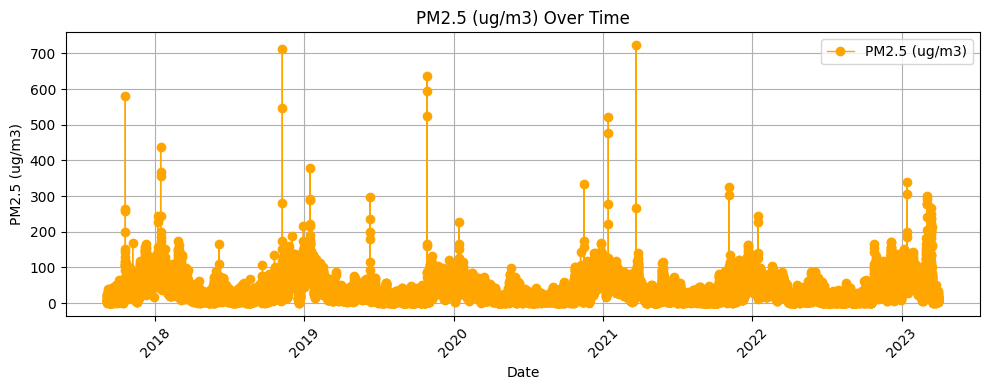

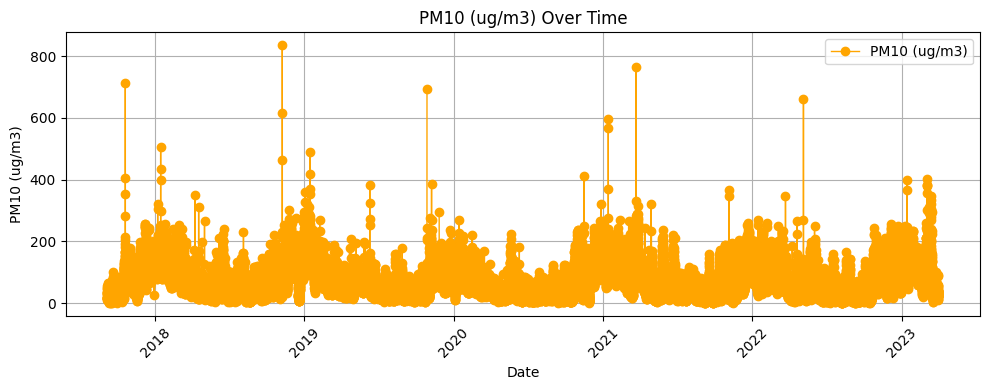

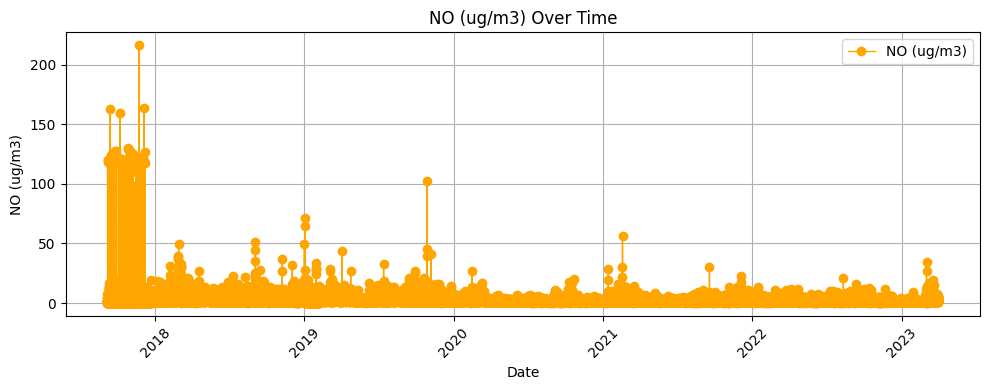

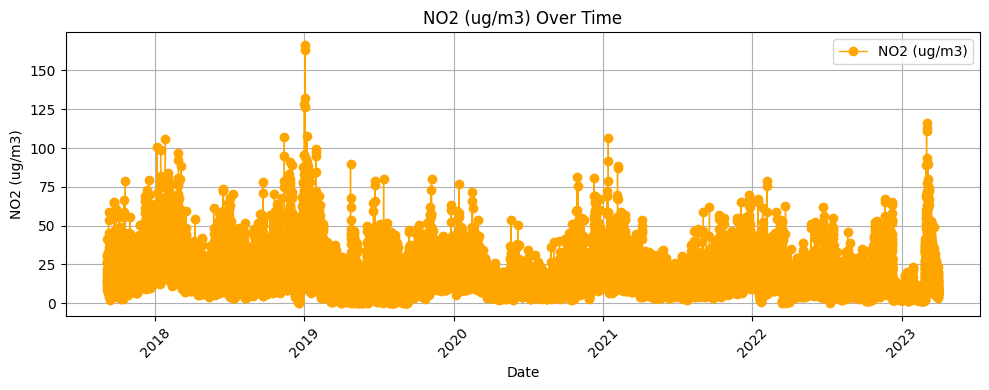

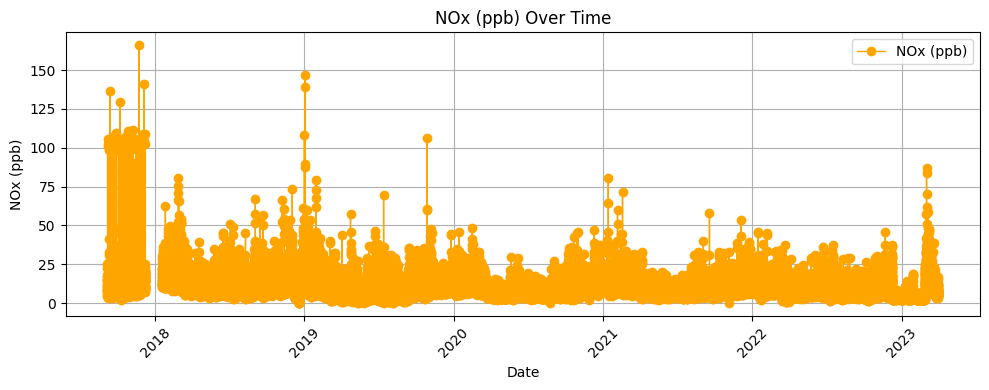

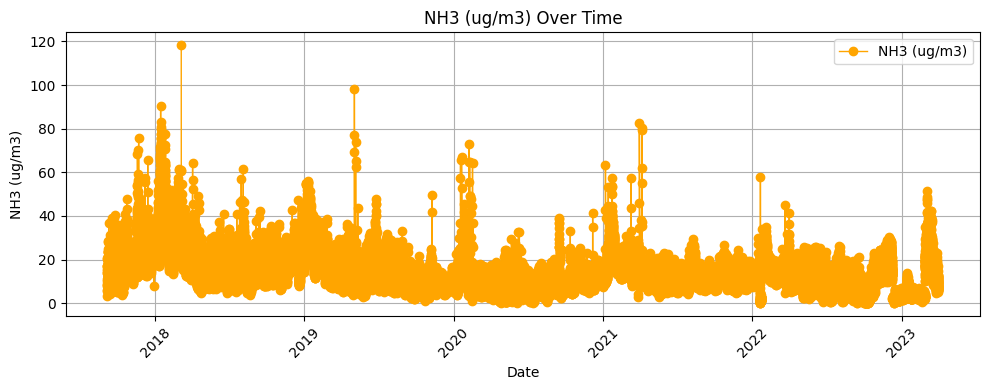

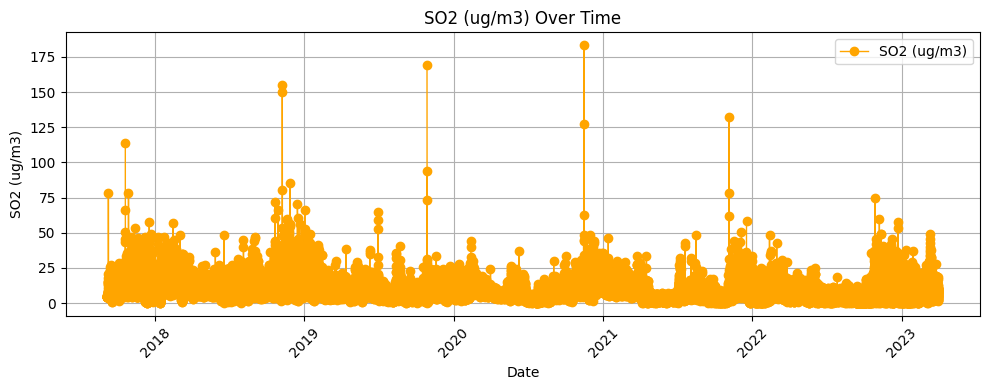

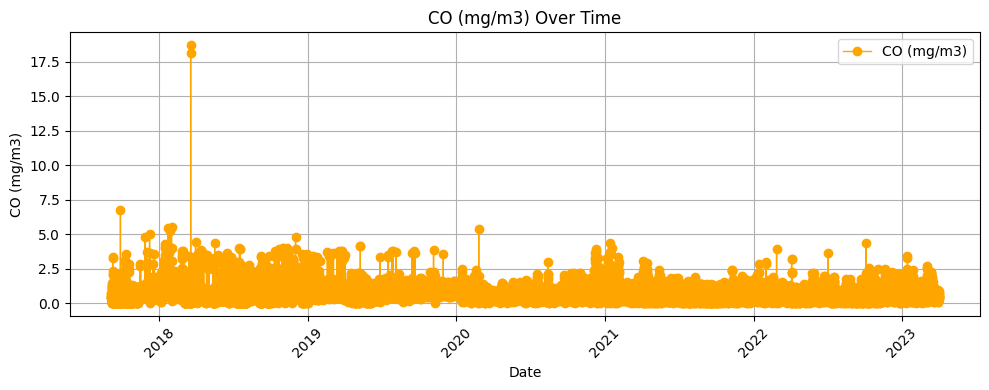

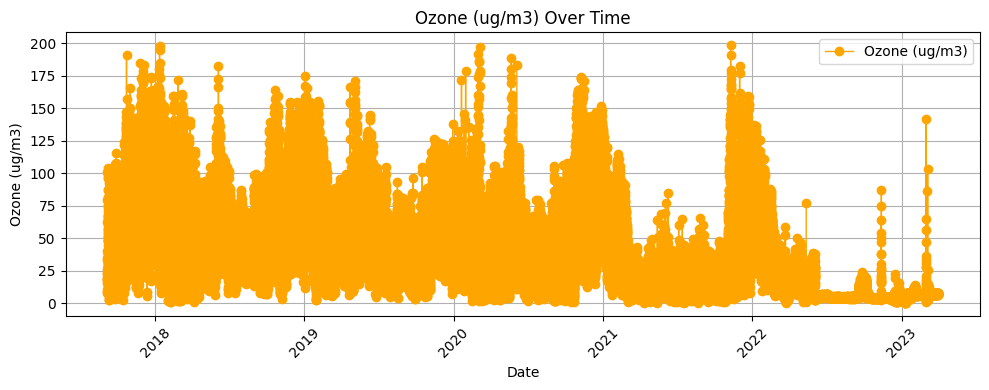

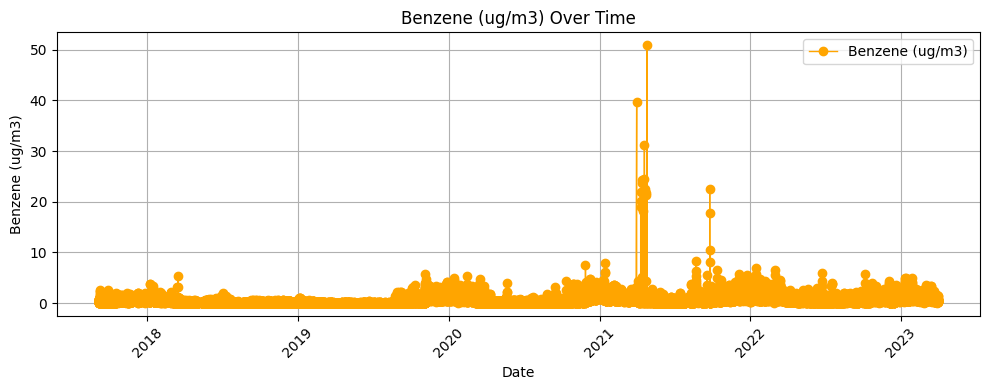

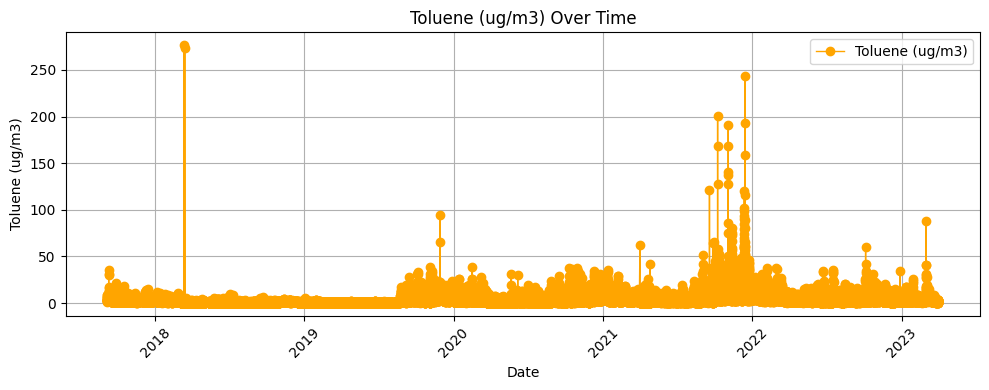

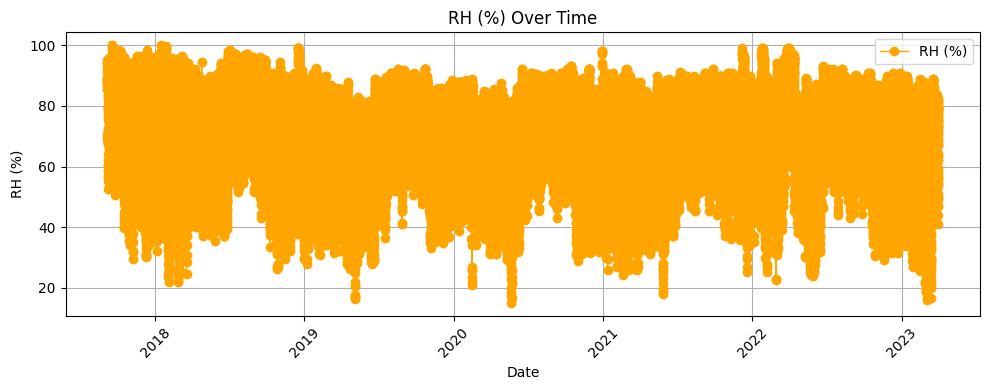

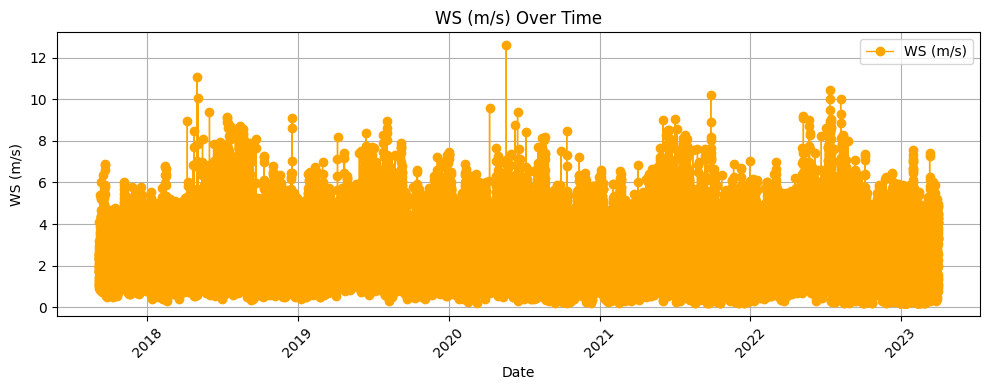

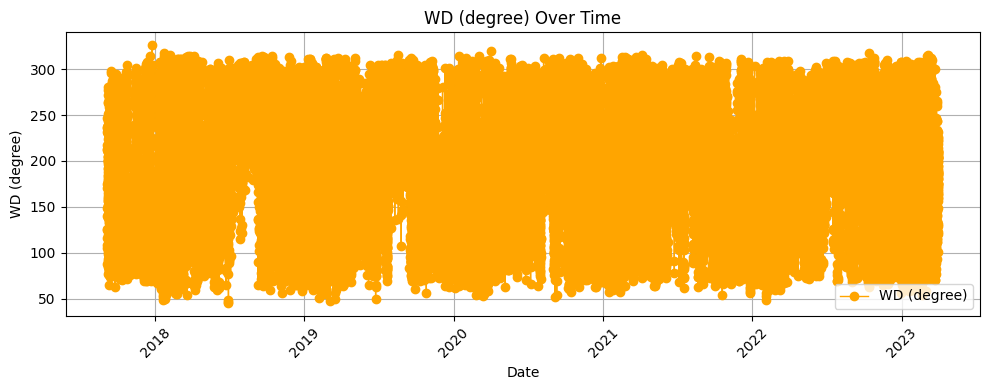

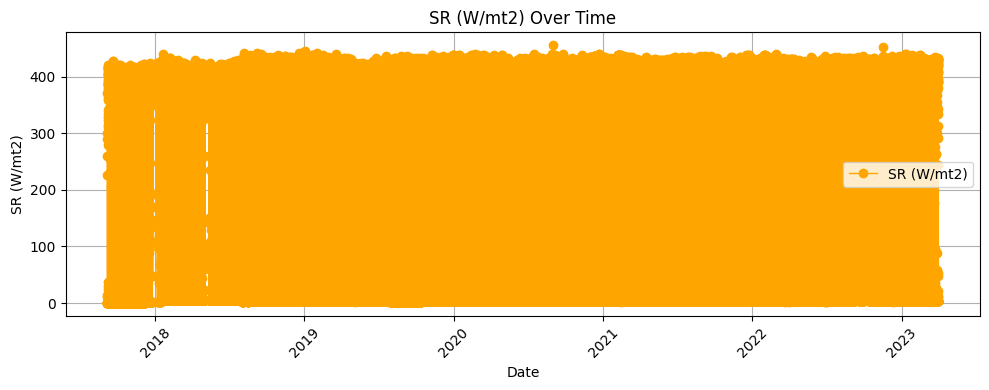

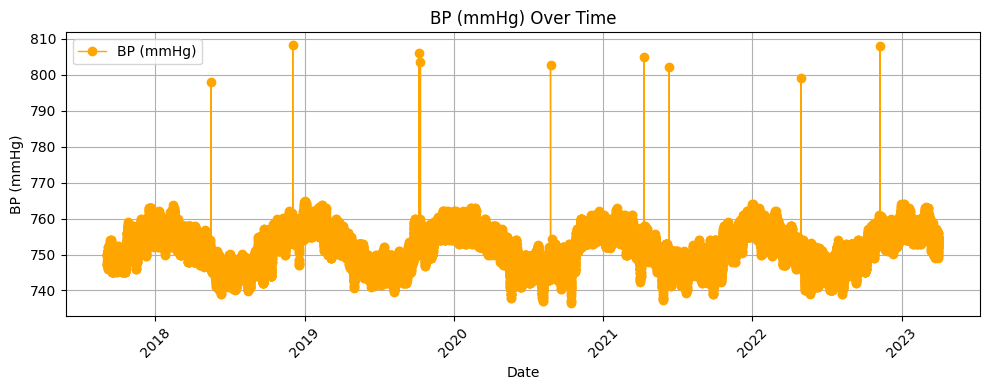

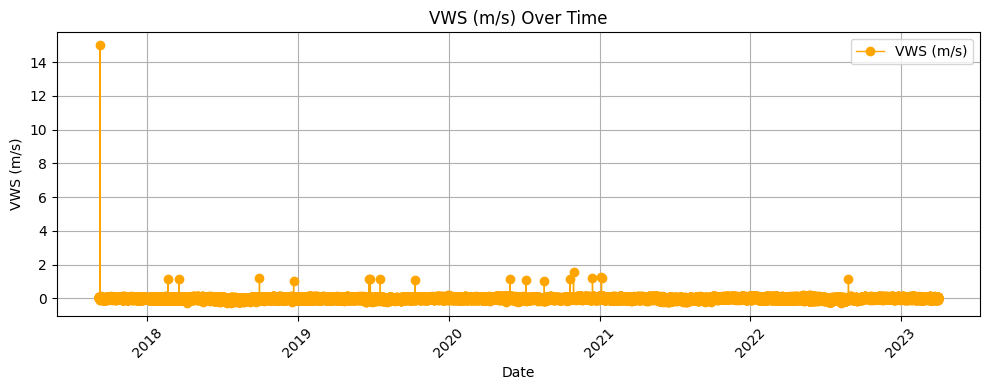

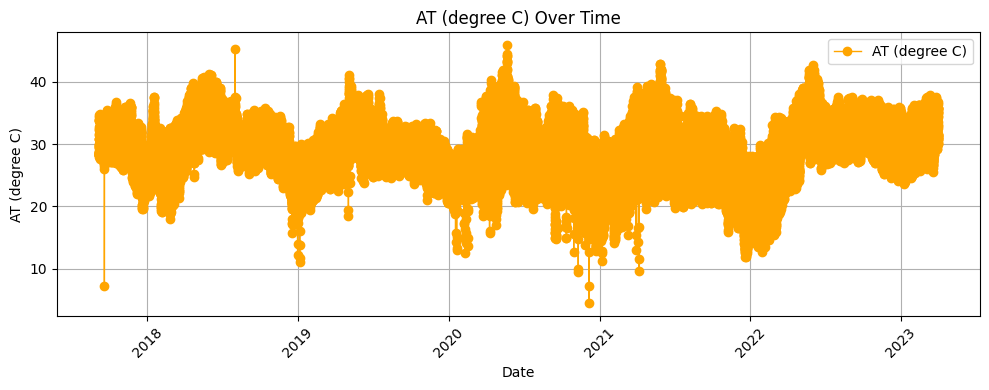

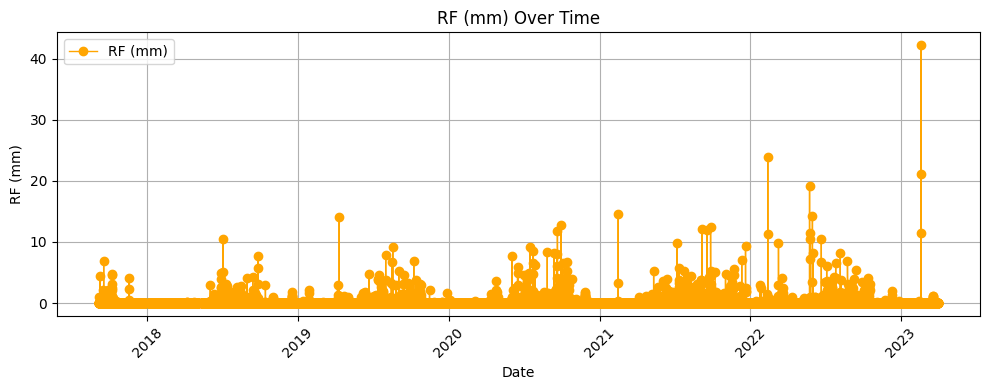

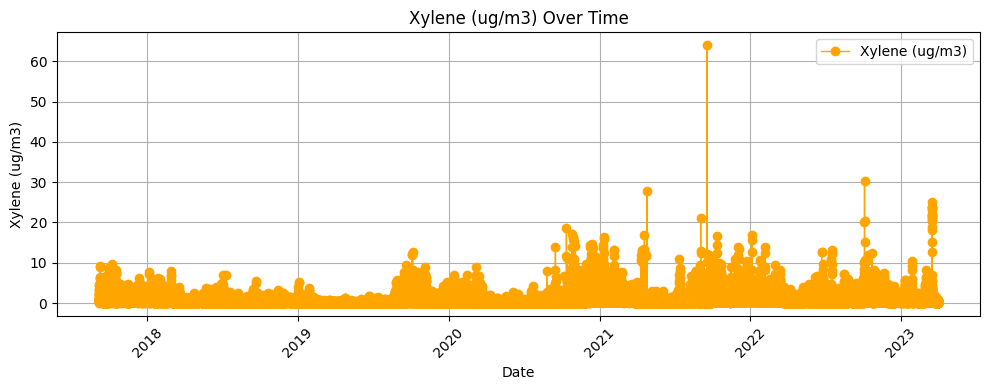

In [55]:
def plot_line_chart(df, columns, date_col='From Date'):
    for col in columns:
        plt.figure(figsize=(10, 4))
        plt.plot(df[date_col], df[col], label=col, marker='o', linewidth=1, color='orange')
        plt.title(f"{col} Over Time")
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()

num_col = [col for col in df.columns if df[col].dtype == 'float']
plot_line_chart(df, num_col)

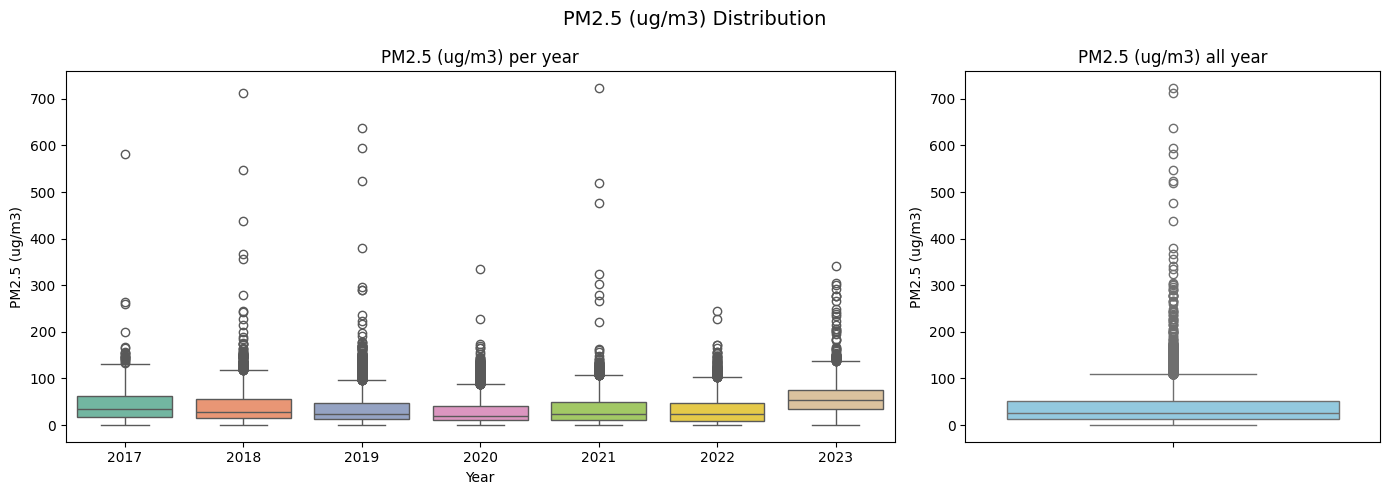

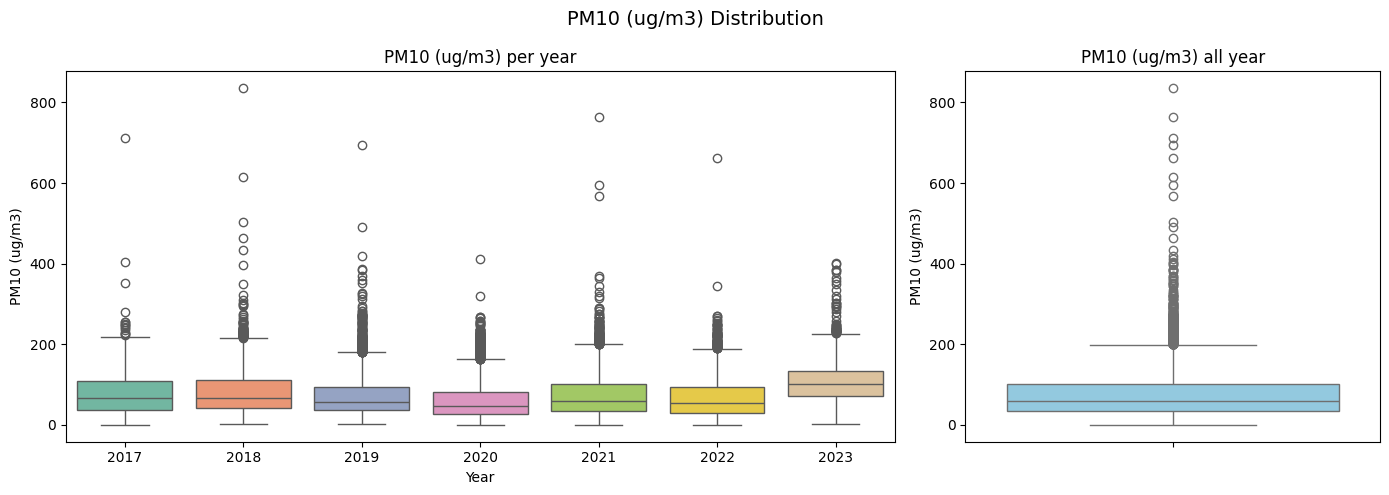

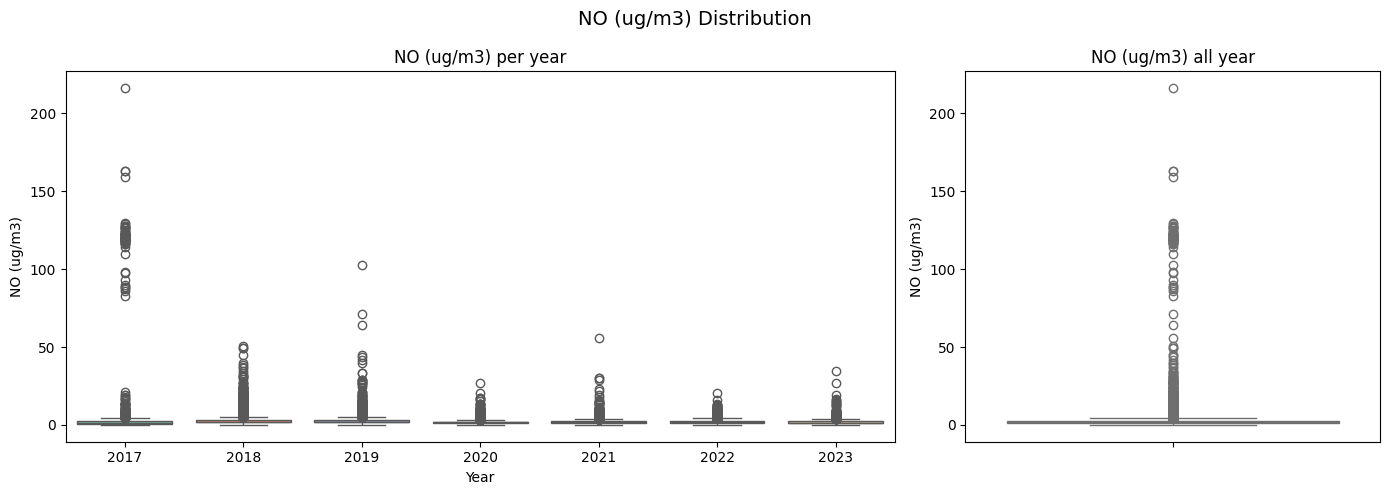

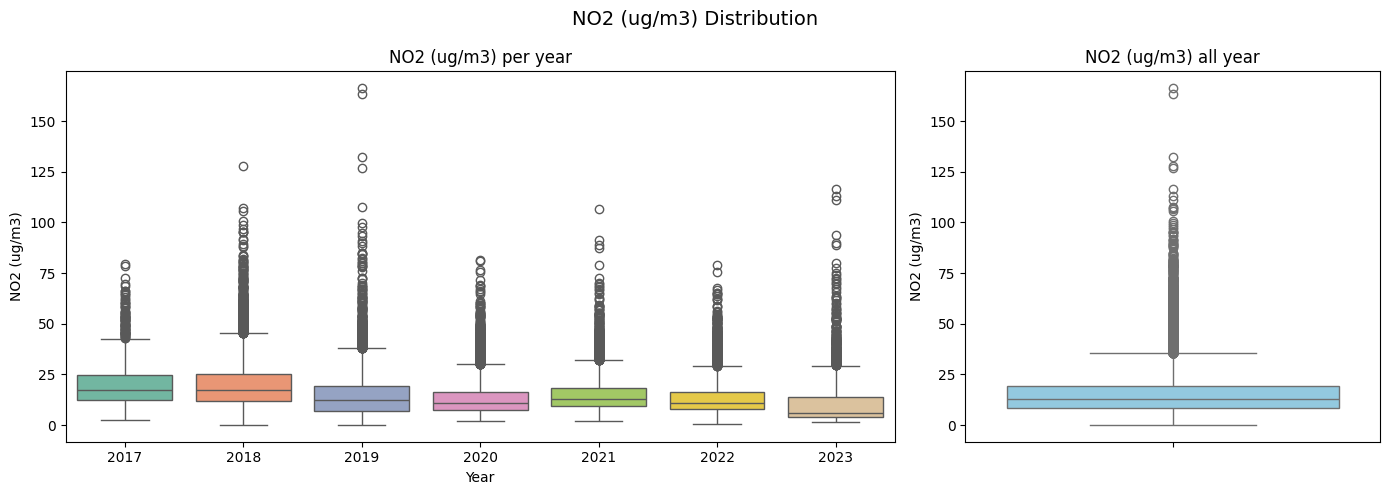

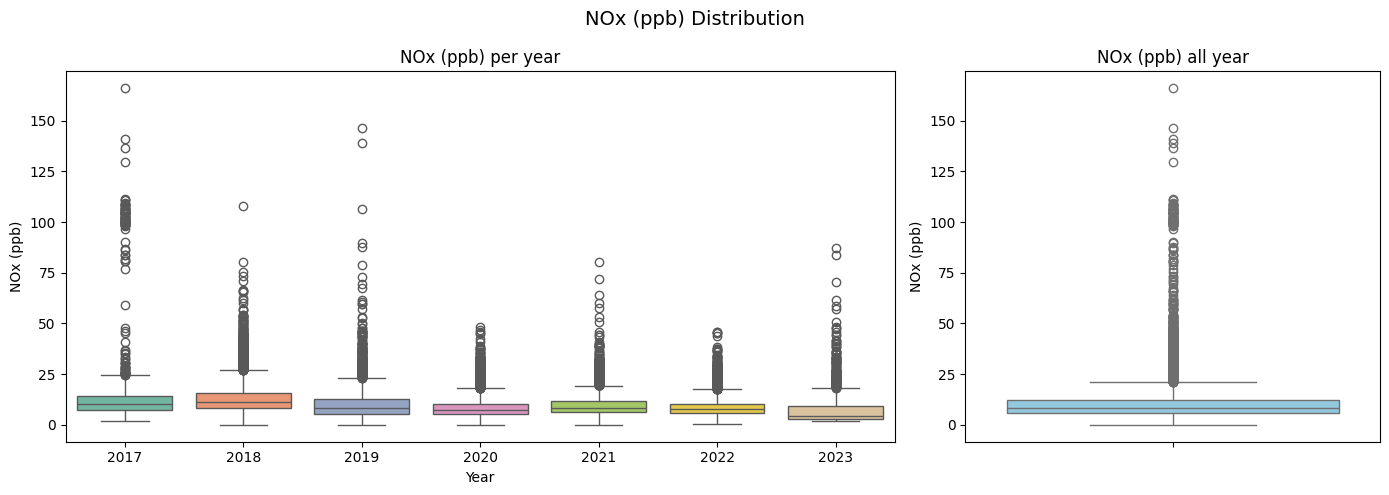

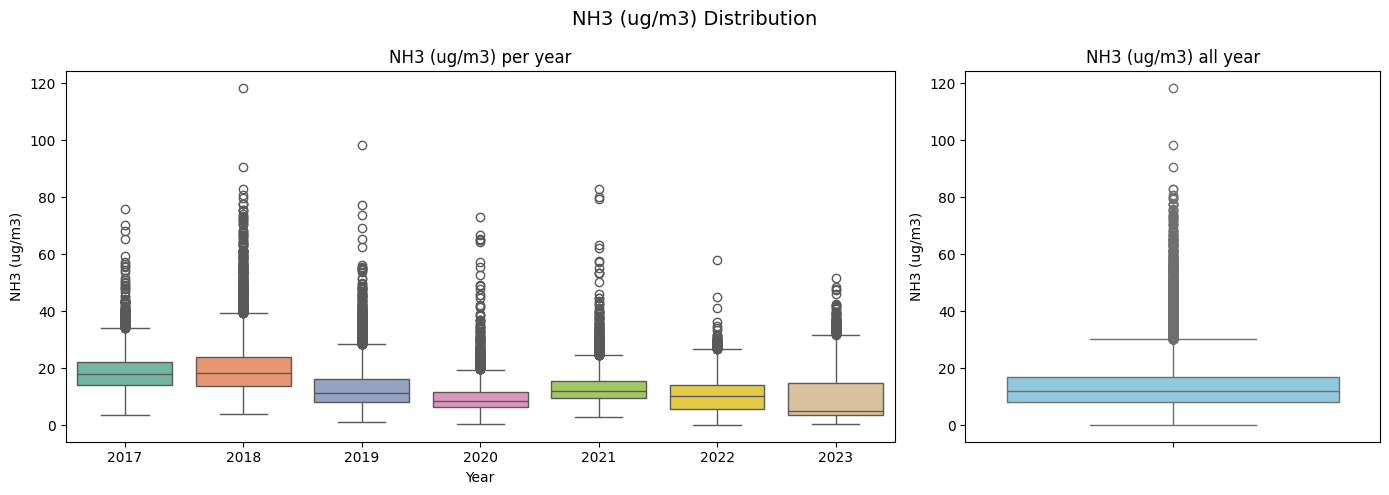

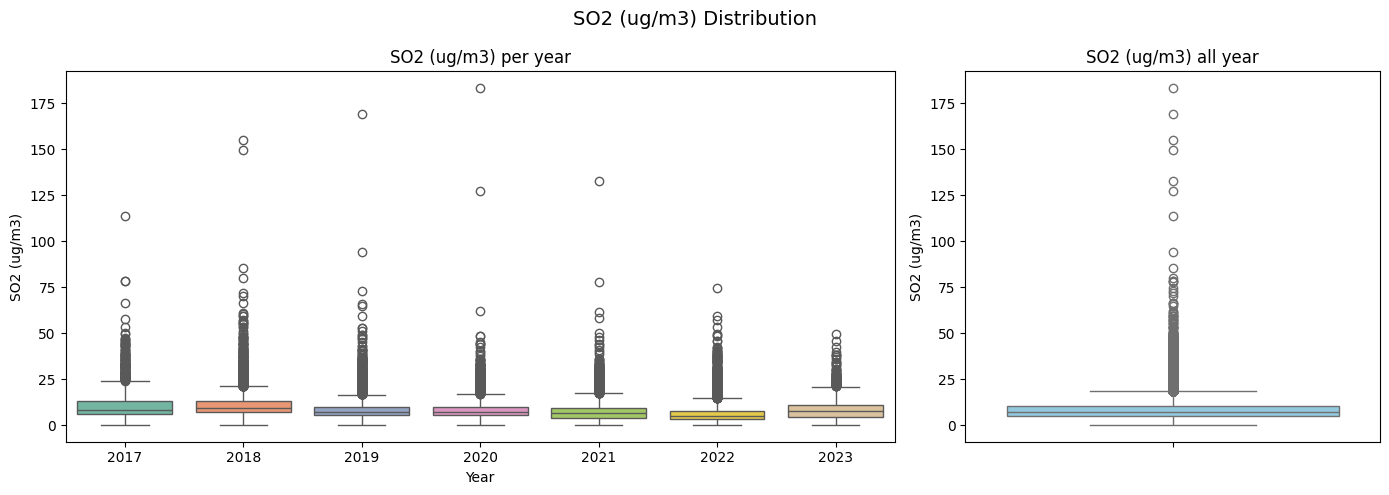

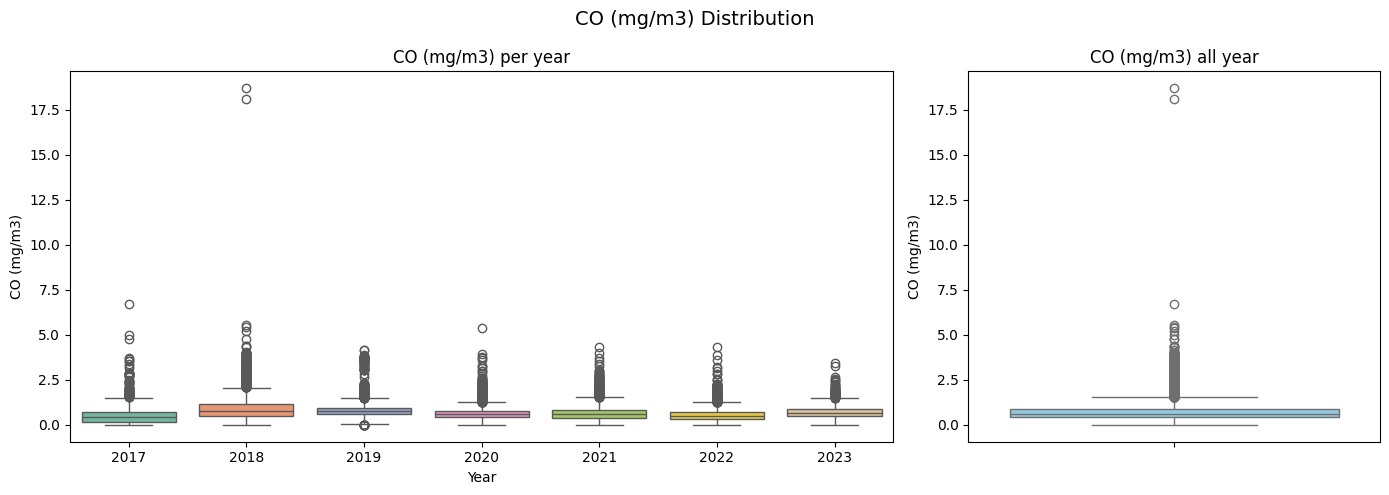

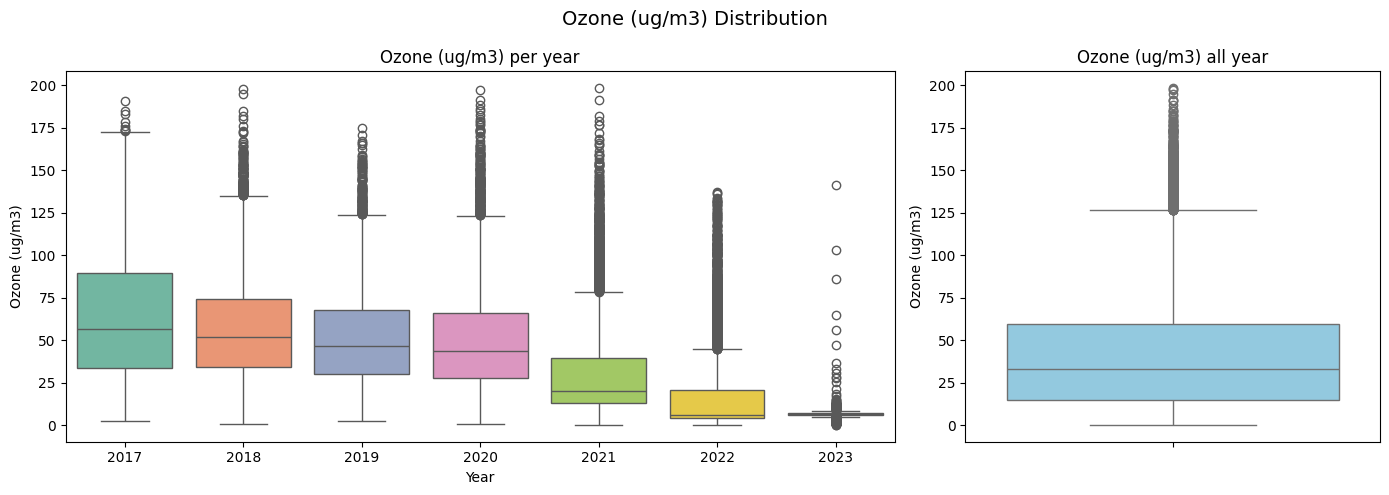

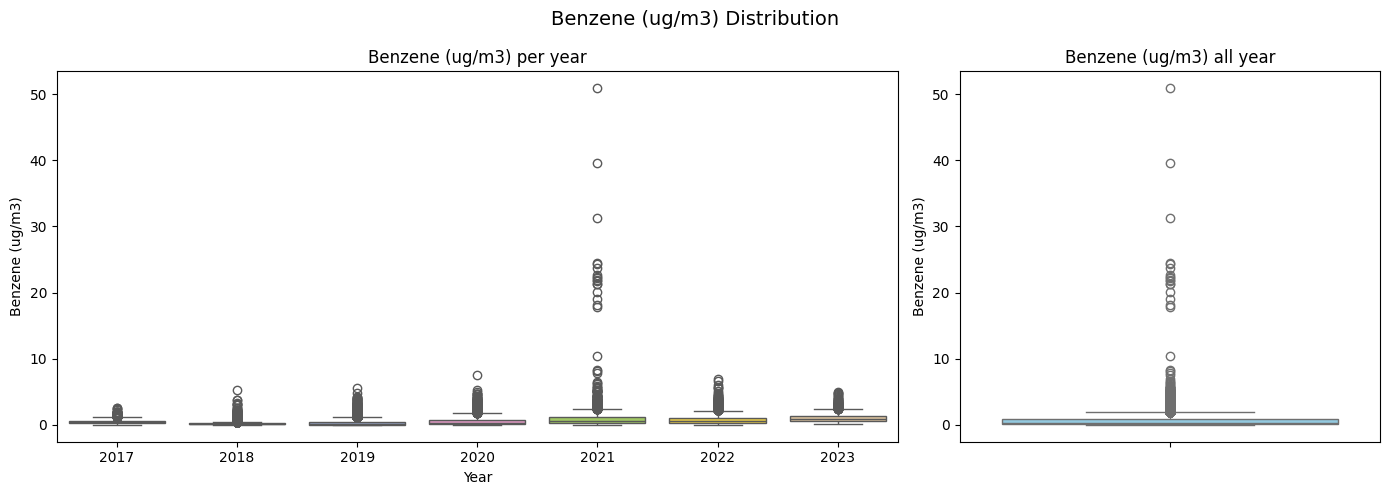

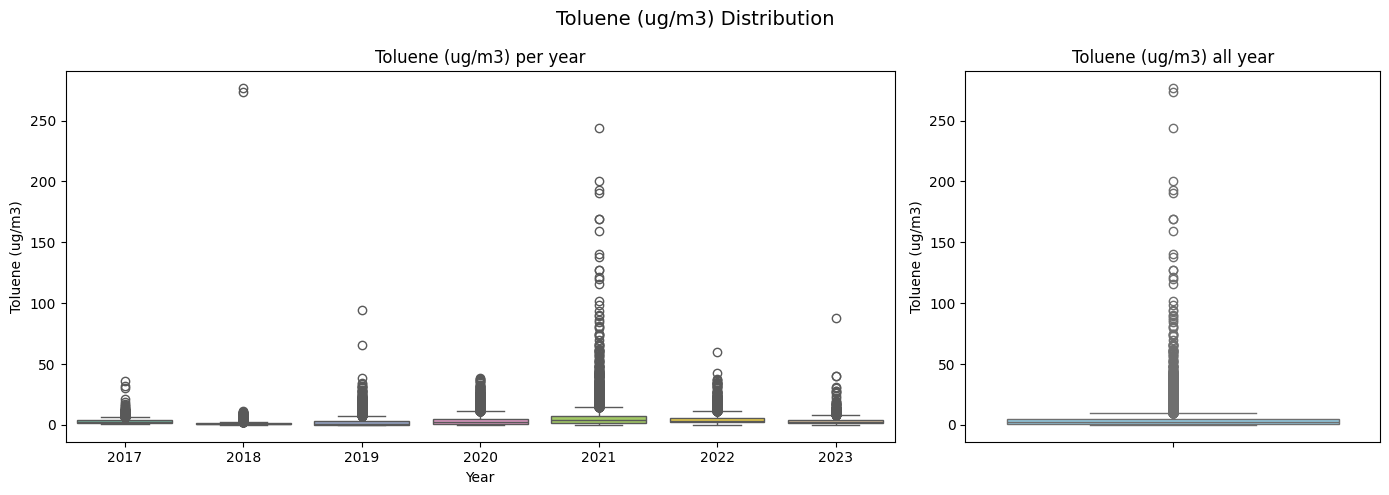

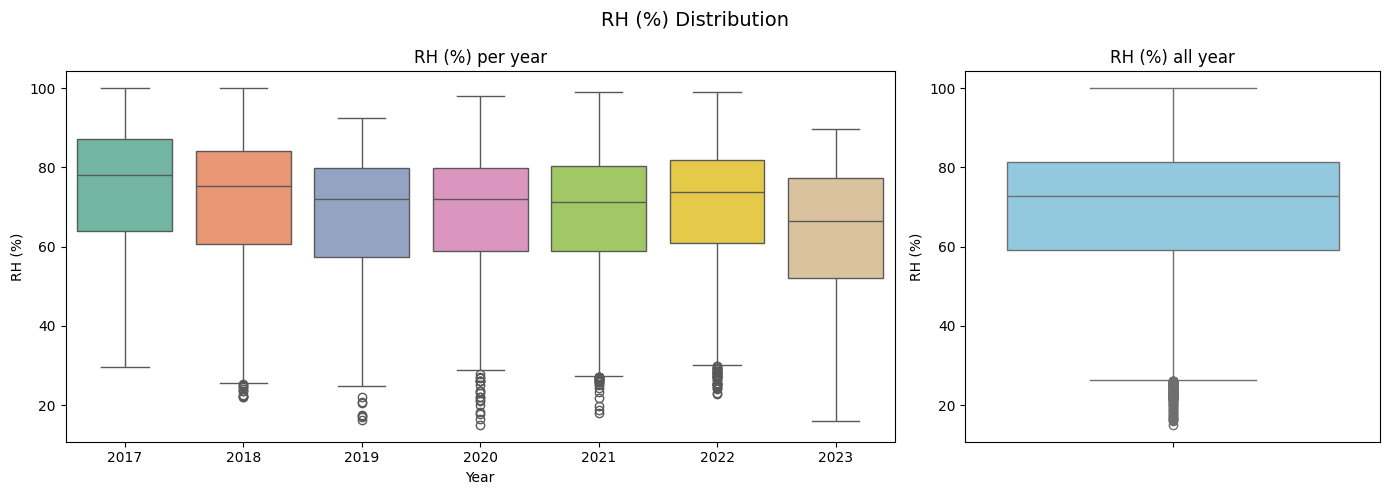

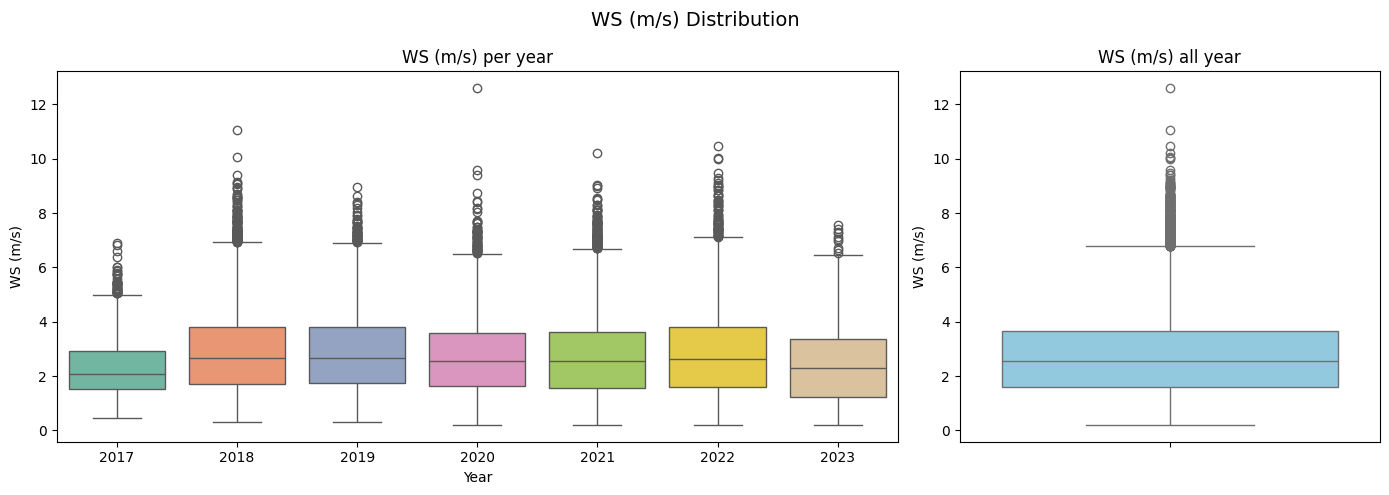

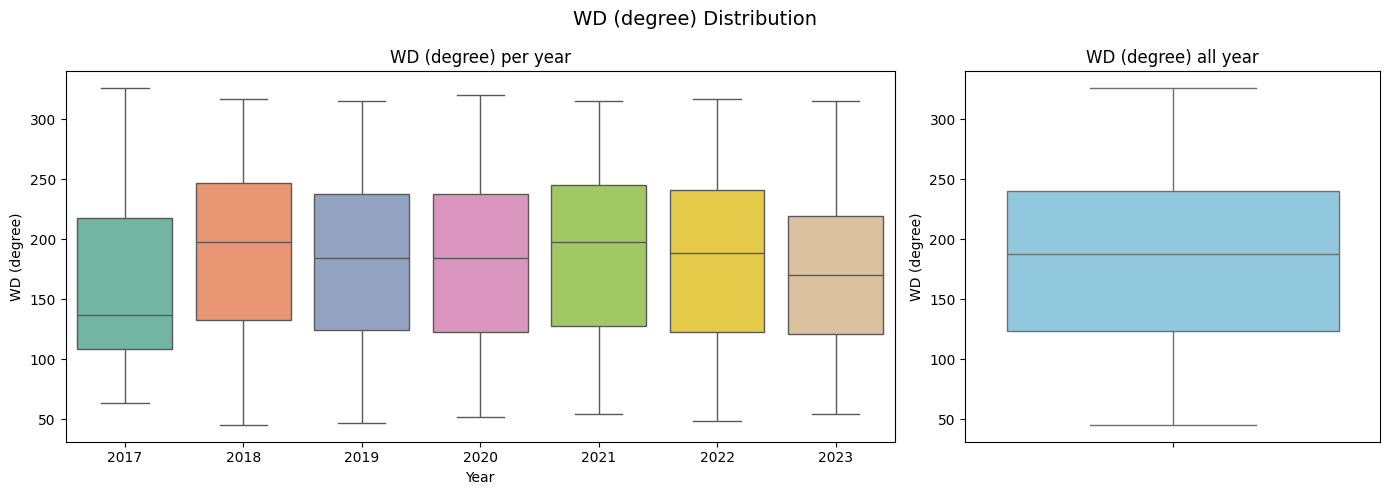

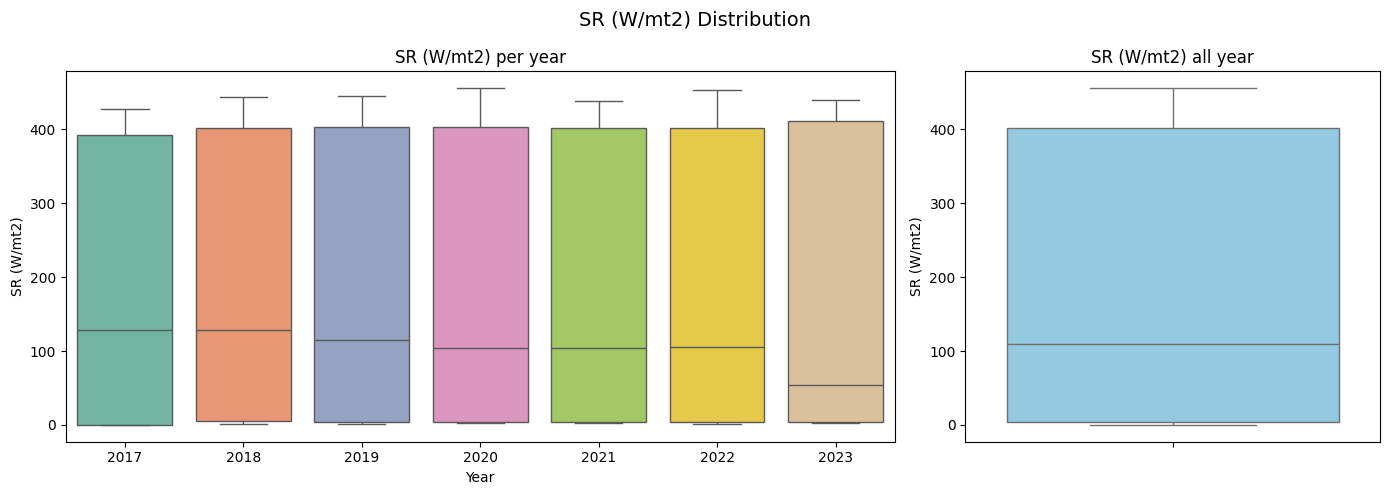

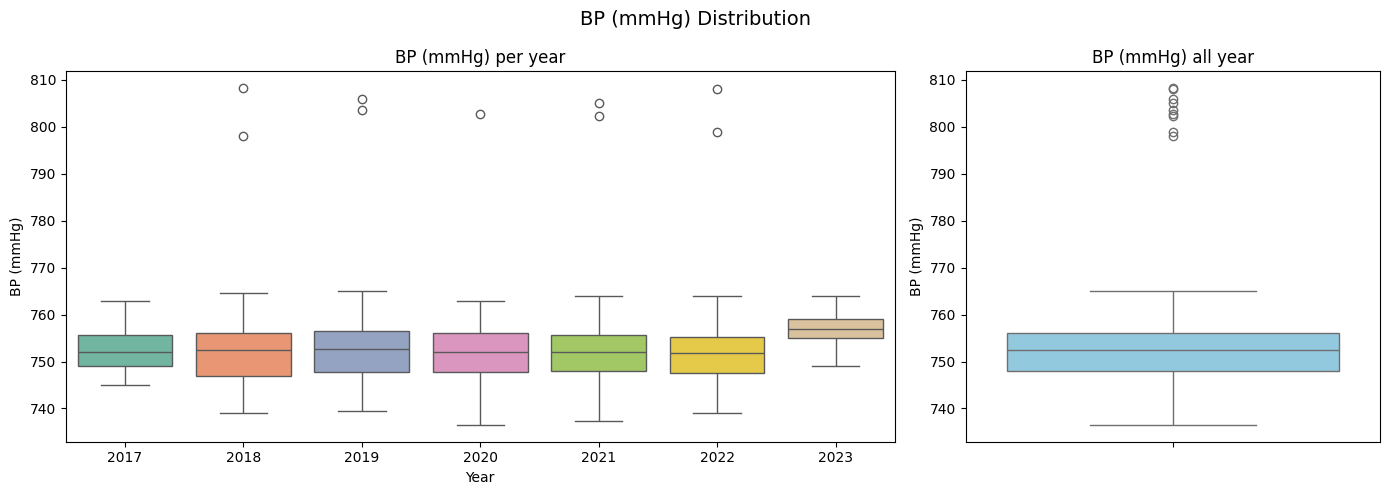

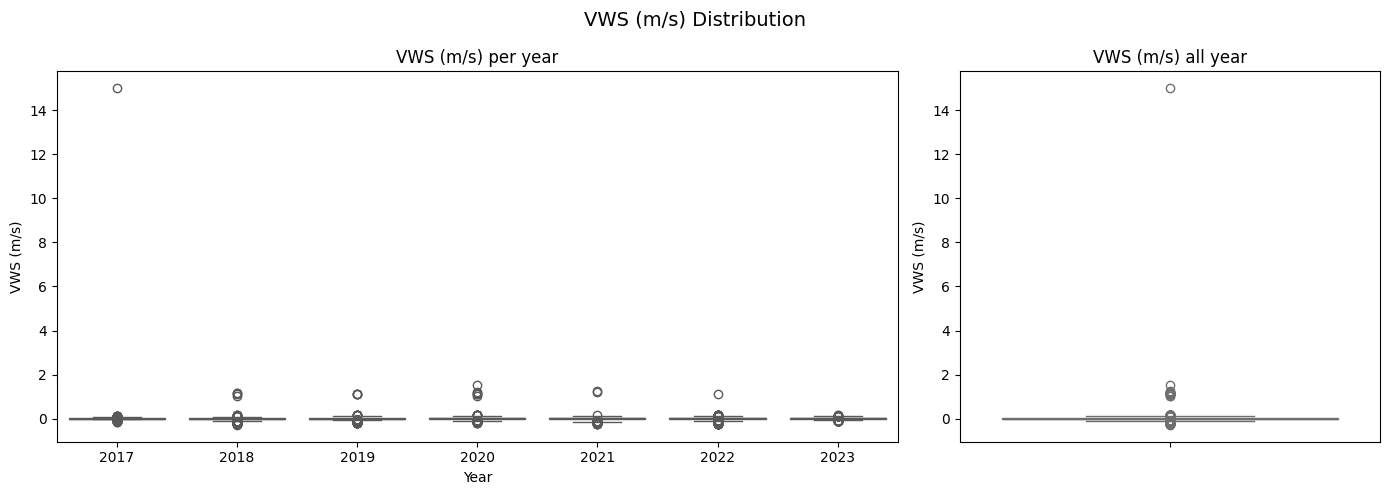

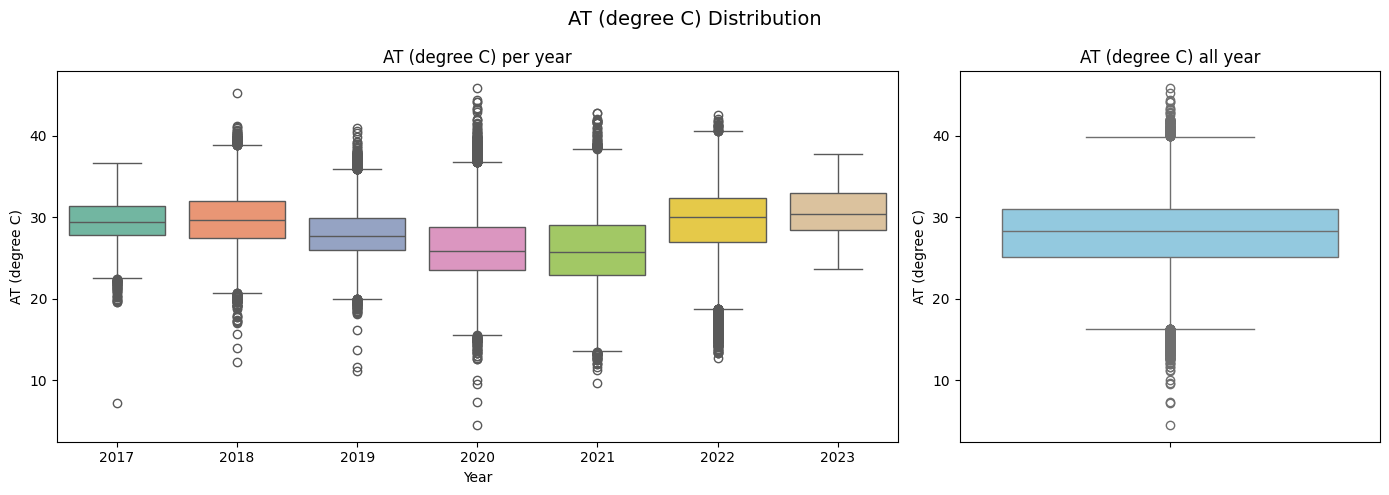

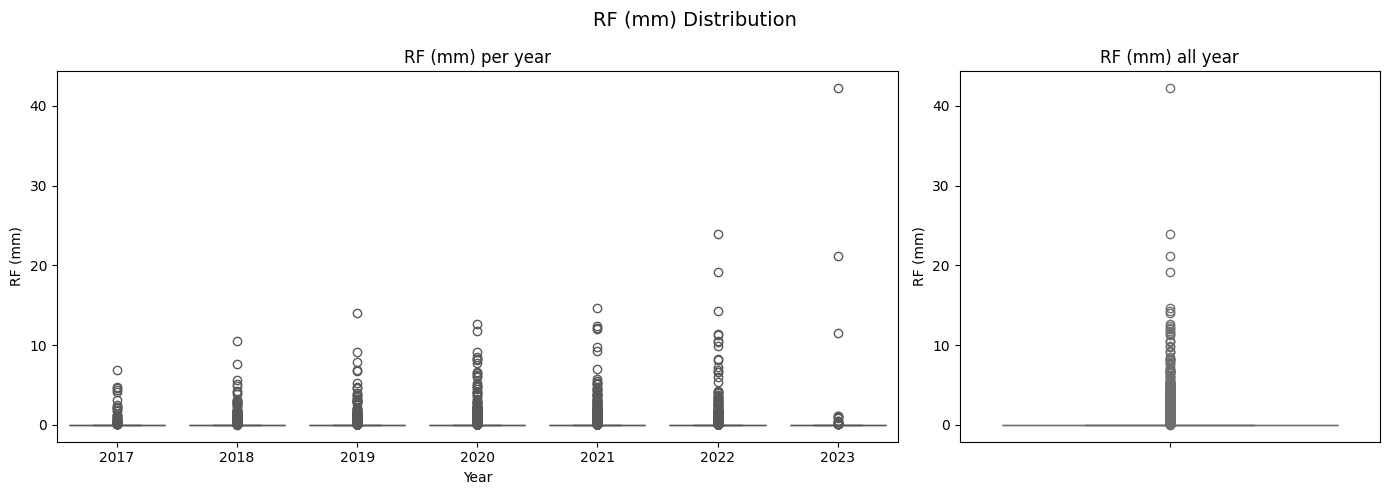

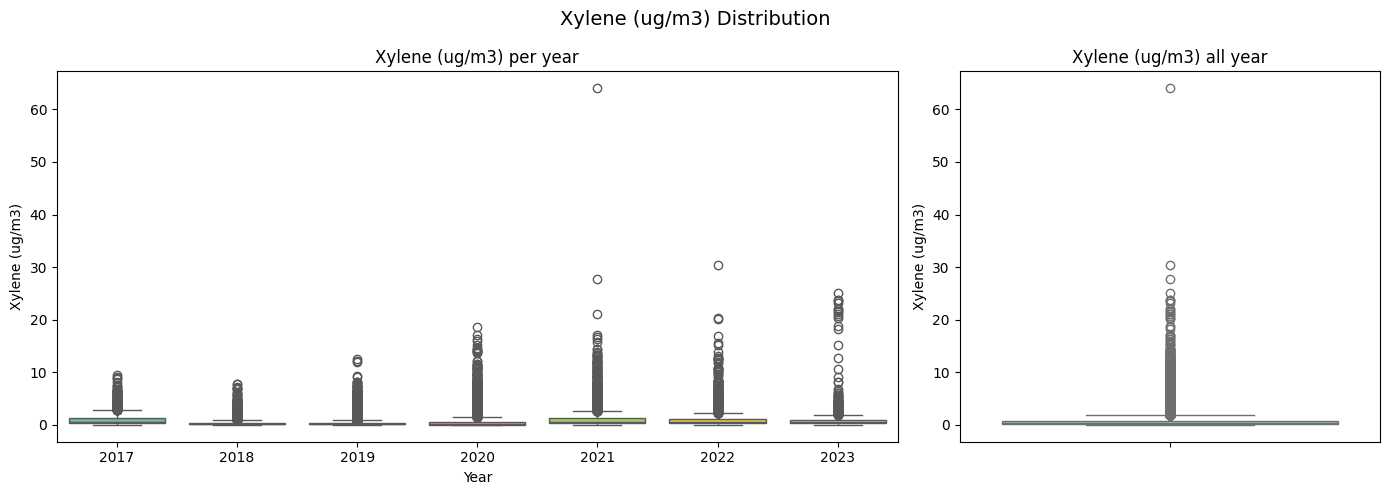

In [56]:
def plot_boxplot(df, columns, date_col='From Date'):
    df['Year'] = df[date_col].dt.year  # Get each year
    for col in columns:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

        # Boxplot each year
        sns.boxplot(x='Year', y=col, data=df, ax=ax[0], hue='Year', palette='Set2', legend=False)
        ax[0].set_title(f"{col} per year")
        ax[0].set_xlabel("Year")
        ax[0].set_ylabel(col)
        ax[0].tick_params(axis='x')

        # Boxplot overall
        sns.boxplot(y=col, data=df, ax=ax[1], color='skyblue')
        ax[1].set_title(f"{col} all year")
        ax[1].set_ylabel(col)
        ax[1].set_xlabel("")

        plt.suptitle(f"{col} Distribution", fontsize=14)
        plt.tight_layout()
        plt.show()
        
plot_boxplot(df, num_col)
df = df.drop("Year", axis = 1)

### Remove extreme outlier

In [57]:
features = [col for col in df.columns if col not in ["AT (degree C)"]]

def remove_outlier(df, cols, bottom=0.01, top=0.99):
    for col in cols:
        low = df[col].quantile(bottom)
        high = df[col].quantile(top)
        df[col] = df[col].clip(low, high)
    return df

df = remove_outlier(df, features)

### Impute Missing value

In [58]:
df.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

In [59]:
df.isnull().sum()

From Date          0
PM2.5 (ug/m3)      0
PM10 (ug/m3)       0
NO (ug/m3)         0
NO2 (ug/m3)        0
NOx (ppb)          0
NH3 (ug/m3)        0
SO2 (ug/m3)        0
CO (mg/m3)         0
Ozone (ug/m3)      0
Benzene (ug/m3)    0
Toluene (ug/m3)    0
RH (%)             0
WS (m/s)           0
WD (degree)        0
SR (W/mt2)         0
BP (mmHg)          0
VWS (m/s)          0
AT (degree C)      0
RF (mm)            0
Xylene (ug/m3)     0
dtype: int64

### Analyze Target

In [60]:
df = df.set_index('From Date')

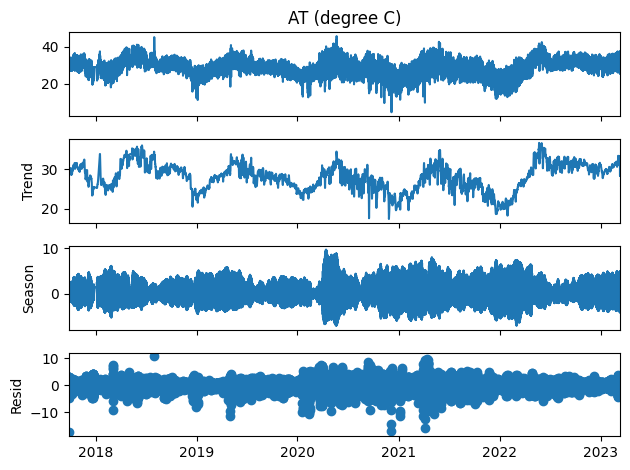

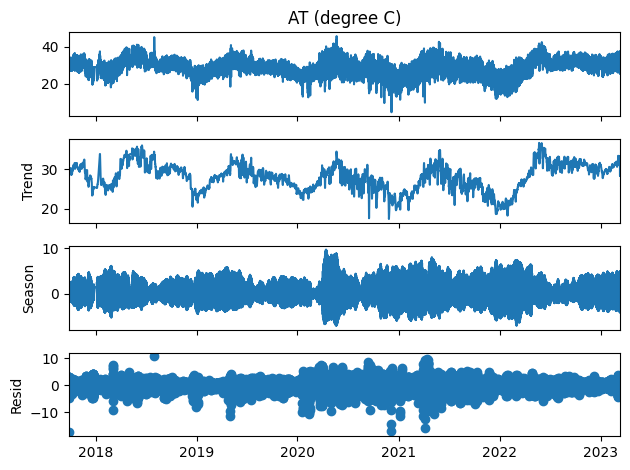

In [61]:
STL(df['AT (degree C)'], period=24, seasonal=13).fit().plot()

**STL Interpretation**:
- Original Series: shows AT fluctuation overtime, it has various pattern between 10-40
- Trend: shows AT Trend over period of 24 period of time
- Season: show AT repetitive pattern
- Resid: indicate "remaining" which trend and seasonal cant tell the data

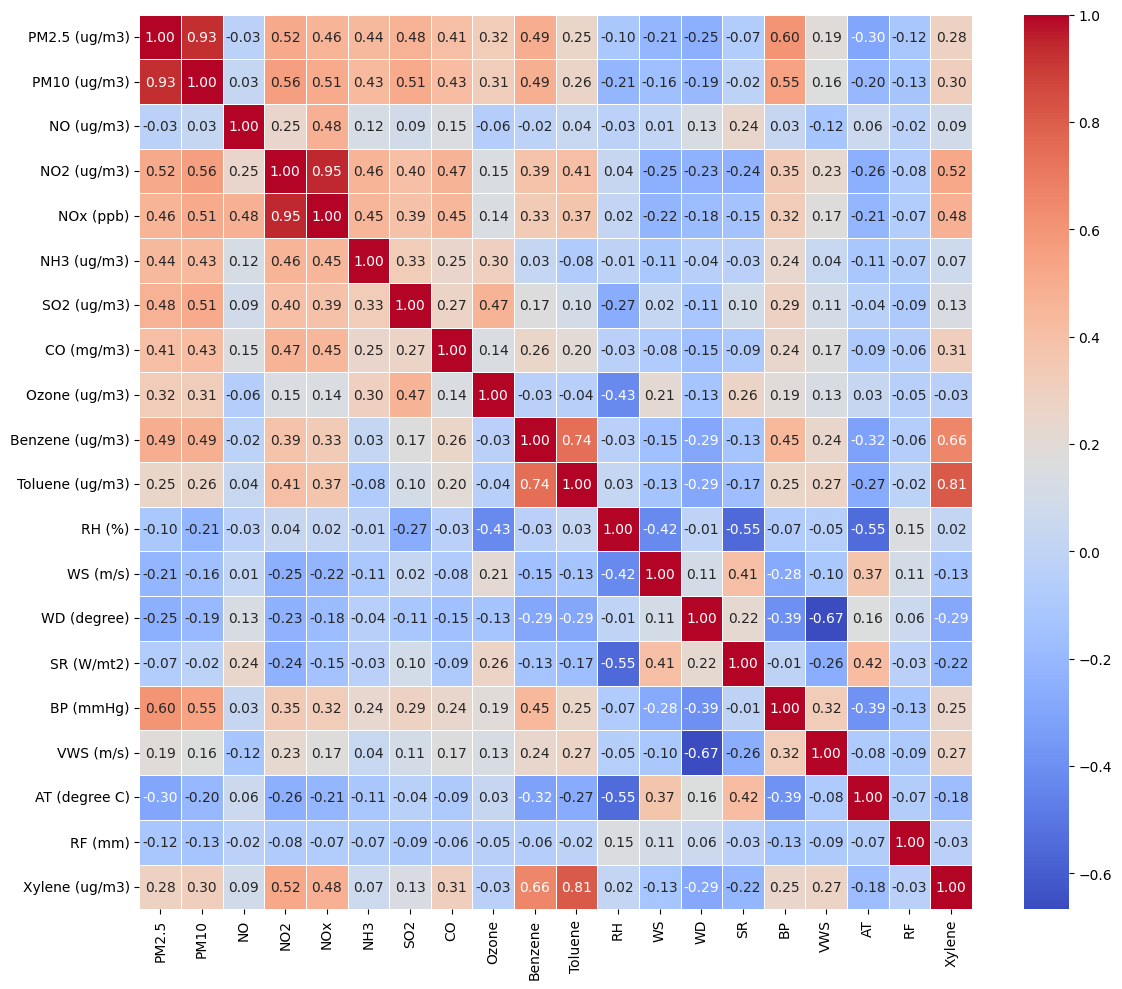

In [62]:
df_corr = df.corr()
df_corr.columns = [col.split('(')[0].strip() for col in df_corr.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.tight_layout()
plt.show()

The correlation matrix only show medium correlation with AT, thhse feature are RH, WS, SR and BP

## Preprocessing

**Splitting Data**

We can't use random splitting for time series data, so we will set

> **80%** older dates as training dataset, then next   
> **10%** as validation data and   
> **10%** as test data

In [63]:
n = len(df) # Total data
df_train = df.iloc[:int(0.8 * n)].copy()
df_val = df.iloc[int(0.8 * n) - WINDOW_SIZE: int(0.9 * n)].copy()
df_test = df.iloc[int(0.9 * n) - WINDOW_SIZE:].copy()

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(37441, 20)
(4685, 20)
(4686, 20)


Before modelling, we need to scale our numeric data, in order to use LSTM model, we will use `MinMaxScaler` for our both features and target

In [64]:
features = [col for col in df.columns if col not in ["AT (degree C)"]]
target = ['AT (degree C)']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

df_train[features] = scaler_X.fit_transform(df_train[features])
df_train[target] = scaler_y.fit_transform(df_train[target])

df_test[features] = scaler_X.transform(df_test[features])
df_test[target] = scaler_y.transform(df_test[target])

df_val[features] = scaler_X.transform(df_val[features])
df_val[target] = scaler_y.transform(df_val[target])


In [65]:
# We need to make function to create dataset that fit to time series, in this case we use window size = 5, that means we will use 5 data
# to predict an output, in this case AT
def create_lstm_dataset(df, feature=features, target=target, window_size=WINDOW_SIZE):
    X, y = [], []
    data = df[feature + target].values
    for i in range(window_size, len(df)):
        X.append(data[i-window_size: i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)


In [66]:
X_train, y_train = create_lstm_dataset(df_train)
X_val, y_val = create_lstm_dataset(df_val)
X_test, y_test = create_lstm_dataset(df_test)

In [67]:
len(X_train), len(X_val), len(X_test)

(37436, 4680, 4681)

## Modelling

### Setting callbacks

**Callbacks**

- **EarlyStopping**: Monitors the validation loss (`val_loss`) and stops training if it does not improve for a specified number of epochs (`patience`). This helps prevent overfitting and saves time by stopping training early when further improvement is unlikely.

- **ReduceLROnPlateau**: Monitors the validation loss and reduces the learning rate by a factor (e.g., 0.5) if the loss does not improve for a certain number of epochs. This helps the model converge better by allowing finer adjustments to weights when progress stalls.

- **ModelCheckpoint**: Saves the model weights to a file whenever the monitored metric (here, `val_loss`) improves. This ensures that the best version of the model is saved during training, which can later be loaded for evaluation or inference.

These callbacks are combined in a list and passed to the `fit()` function during model training to automate and optimize the training process.

In [68]:
callbacks_baseline = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
    ModelCheckpoint('models/baseline/best_model.h5', save_best_only=True, monitor='val_loss')
]

callbacks_modification = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
    ModelCheckpoint('models/modification/best_model.h5', save_best_only=True, monitor='val_loss')
]

### Baseline Model

In [69]:
def build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2])):
    model = Sequential()
    model.add(LSTM(units=10, input_shape=input_shape))  
    model.add(Dense(units=1, activation='linear'))     
    return model

In [70]:
model = build_lstm_model()

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['mae', 'mse']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                1200      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,211
Trainable params: 1,211
Non-trainable params: 0
_________________________________________________________________


In [71]:
baseline = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks_baseline,
    verbose=1
)

Epoch 1/20
1170/1170 [==============================] - 8s 6ms/step - loss: 0.0117 - mae: 0.0641 - mse: 0.0117 - val_loss: 0.0457 - val_mae: 0.1987 - val_mse: 0.0457 - lr: 0.0010
Epoch 2/20
1170/1170 [==============================] - 7s 6ms/step - loss: 0.0027 - mae: 0.0388 - mse: 0.0027 - val_loss: 0.0432 - val_mae: 0.1957 - val_mse: 0.0432 - lr: 0.0010
Epoch 3/20
1170/1170 [==============================] - 7s 6ms/step - loss: 0.0025 - mae: 0.0362 - mse: 0.0025 - val_loss: 0.0415 - val_mae: 0.1927 - val_mse: 0.0415 - lr: 0.0010
Epoch 4/20
1170/1170 [==============================] - 7s 6ms/step - loss: 0.0024 - mae: 0.0353 - mse: 0.0024 - val_loss: 0.0396 - val_mae: 0.1885 - val_mse: 0.0396 - lr: 0.0010
Epoch 5/20
1170/1170 [==============================] - 6s 6ms/step - loss: 0.0023 - mae: 0.0347 - mse: 0.0023 - val_loss: 0.0381 - val_mae: 0.1850 - val_mse: 0.0381 - lr: 0.0010
Epoch 6/20
1170/1170 [==============================] - 7s 6ms/step - loss: 0.0023 - mae: 0.0342 - mse: 0

### Modification Model

For modification model we will try to optimize using Dropout and Batchnormalization and also add LSTM units. Let's se how it will differ from baseline model

In [72]:
def build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2])):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="linear"))
    return model

In [73]:
model2 = build_lstm_model()

model2.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['mae', 'mse']) 
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 64)             21504     
                                                                 
 dropout_2 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                      

In [74]:

modification = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks_modification,
    verbose=1
)

Epoch 1/20
1170/1170 [==============================] - 13s 9ms/step - loss: 0.0656 - mae: 0.1532 - mse: 0.0656 - val_loss: 0.0712 - val_mae: 0.2497 - val_mse: 0.0712 - lr: 0.0010
Epoch 2/20
1170/1170 [==============================] - 10s 8ms/step - loss: 0.0064 - mae: 0.0615 - mse: 0.0064 - val_loss: 0.0654 - val_mae: 0.2382 - val_mse: 0.0654 - lr: 0.0010
Epoch 3/20
1170/1170 [==============================] - 10s 8ms/step - loss: 0.0045 - mae: 0.0514 - mse: 0.0045 - val_loss: 0.0661 - val_mae: 0.2405 - val_mse: 0.0661 - lr: 0.0010
Epoch 4/20
1170/1170 [==============================] - 10s 8ms/step - loss: 0.0039 - mae: 0.0471 - mse: 0.0039 - val_loss: 0.0653 - val_mae: 0.2388 - val_mse: 0.0653 - lr: 0.0010
Epoch 5/20
1170/1170 [==============================] - 10s 8ms/step - loss: 0.0036 - mae: 0.0452 - mse: 0.0036 - val_loss: 0.0759 - val_mae: 0.2615 - val_mse: 0.0759 - lr: 0.0010
Epoch 6/20
1170/1170 [==============================] - 10s 8ms/step - loss: 0.0034 - mae: 0.0442 - 

### Hyperparameter Model

We will try hyperparameter tuning on modification model by tune LTSM neurons, Dropout, and the Adam optimizer (learning rate)

In [75]:
def build_model(hp):
    model = Sequential()

    # LSTM Layer 1
    model.add(LSTM(
        units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # LSTM Layer 2
    model.add(LSTM(units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Optional BatchNormalization
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(1, activation="linear"))

    # Compile the model
    model.compile(
        optimizer=Adam(hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='mse',
        metrics=['mae']
    )

    return model

In [76]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='lstm_model_tuning'
)


tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)
tuner.results_summary()

best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from lstm_tuning\lstm_model_tuning\tuner0.json
Results summary
Results in lstm_tuning\lstm_model_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
lstm_units_1: 64
dropout_1: 0.30000000000000004
lstm_units_2: 64
dropout_2: 0.1
lr: 0.0022392459954504915
Score: 0.003763778368011117

Trial 08 summary
Hyperparameters:
lstm_units_1: 96
dropout_1: 0.30000000000000004
lstm_units_2: 16
dropout_2: 0.1
lr: 0.006320810242350413
Score: 0.003955445252358913

Trial 04 summary
Hyperparameters:
lstm_units_1: 64
dropout_1: 0.2
lstm_units_2: 16
dropout_2: 0.1
lr: 0.0018761421496988281
Score: 0.004389551933854818

Trial 07 summary
Hyperparameters:
lstm_units_1: 32
dropout_1: 0.2
lstm_units_2: 32
dropout_2: 0.5
lr: 0.001011301998929244
Score: 0.005126984789967537

Trial 06 summary
Hyperparameters:
lstm_units_1: 96
dropout_1: 0.2
lstm_units_2: 48
dropout_2: 0.1
lr: 0.0010819417247008444
Score: 0.005431151017546654

Trial 05 summary


In [77]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best parameter: ", best_hp.values)

Best parameter:  {'lstm_units_1': 64, 'dropout_1': 0.30000000000000004, 'lstm_units_2': 64, 'dropout_2': 0.1, 'lr': 0.0022392459954504915}


## Train Evaluation

In [78]:
def plot_evaluation(history, title):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot MAE
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['mae'], 'b-', label='Train MAE')
    plt.plot(epochs, history.history['val_mae'], 'r--', label='Val MAE')
    plt.title('MAE per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    # Plot MSE (loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Train MAE')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Val MAE')
    plt.title('MSE (Loss) per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.suptitle(f"{title} Model")
    plt.tight_layout()
    plt.show()
    

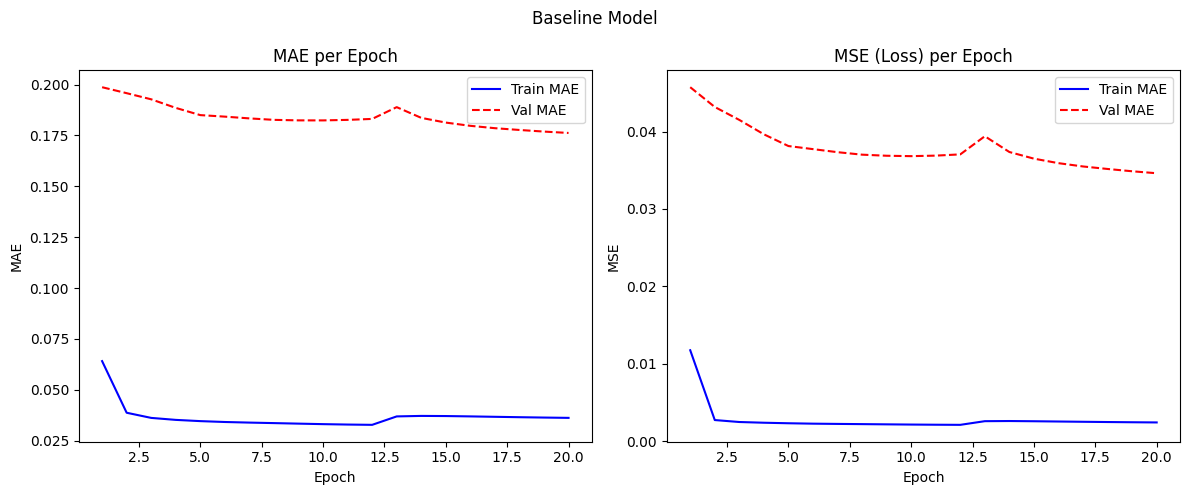

In [79]:
plot_evaluation(baseline, title="Baseline")

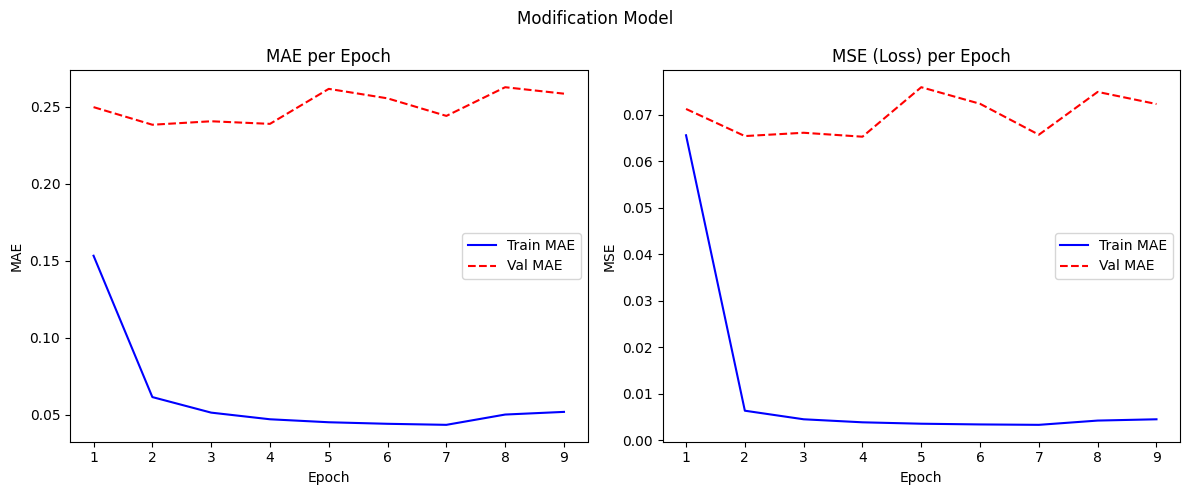

In [80]:
plot_evaluation(modification, title="Modification")

From the train set we see the baseline model has better performance with decreasing validation loss.

## Test Evaluation

In [81]:
y_pred = model.predict(X_test)

147/147 [==============================] - 1s 2ms/step


In [82]:
y_pred_modification = model2.predict(X_test)

147/147 [==============================] - 1s 3ms/step


In [83]:
y_pred_tuning = best_model.predict(X_test)

147/147 [==============================] - 1s 3ms/step


In [84]:
def evaluate_inversed(metrics, y_test, y_pred):
    y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    return metrics(y_test_inverse, y_pred_inverse)
    

In [85]:
print("Baseline Test model MAE: ", evaluate_inversed(mean_absolute_error, y_test, y_pred))
print("Baseline Test model MSE: ", evaluate_inversed(mean_squared_error, y_test, y_pred))
print("Baseline Test model R2: ", evaluate_inversed(r2_score, y_test, y_pred))

print("==" * 20)

print("Modification Test model MAE: ", evaluate_inversed(mean_absolute_error, y_pred_modification, y_pred))
print("Modification Test model MSE: ", evaluate_inversed(mean_squared_error, y_pred_modification, y_pred))
print("Modification Test model R2: ", evaluate_inversed(r2_score, y_pred_modification, y_pred))

print("==" * 20)

print("Hyperparameter Test model MAE: ", evaluate_inversed(mean_absolute_error, y_pred_tuning, y_pred))
print("Hyperparameter Test model MSE: ", evaluate_inversed(mean_squared_error, y_pred_tuning, y_pred))
print("Hyperparameter Test model R2: ", evaluate_inversed(r2_score, y_pred_tuning, y_pred))

Baseline Test model MAE:  8.157016402776108
Baseline Test model MSE:  75.08067763696906
Baseline Test model R2:  -9.357645111481776
Modification Test model MAE:  1.87135910987854
Modification Test model MSE:  6.122330665588379
Modification Test model R2:  0.6858447790145874
Hyperparameter Test model MAE:  6.3485307693481445
Hyperparameter Test model MSE:  48.72929382324219
Hyperparameter Test model R2:  -3.7482247352600098


Test Evaluation shows modification model has a lot of better performance than the baseline, indicate overfitting on baseline model.

Modification model might better caused of some layer such as dropout and batchnormalization, also the modification model seems more adaptif with the model shows good fit 

Hyperparameter model might need more trials as we see it dont really show good fit